<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/learning_tf_save_image_as_tfrec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

Based on tutorial at https://codelabs.developers.google.com/codelabs/keras-flowers-data/#4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Imports

In [ ]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

Tensorflow version 2.4.1


#Configuration

In [ ]:
PATH_PATTERN = '/content/drive/MyDrive/Colab Notebooks/clickbait_detection/thumbnails/*/*.jpg'
PATH_OUTPUT = '/content/drive/MyDrive/Colab Notebooks/clickbait_detection/root_dataset/tfrec_image_data/tfrecords-jpeg-180x180-nnn/thumbnails'
CLASSES = [b'clickbaits', b'nonclickbaits'] # image labels (folder names in the data)

SHARDS = 16
TARGET_SIZE = [180, 180]

In [ ]:
#@title "display utilities [RUN ME]"
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(label.numpy().decode("utf-8"), fontsize=16)
    subplot += 1
    if i==8:
      break
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

#Read images and labels

In [ ]:
nb_images = len(tf.io.gfile.glob(PATH_PATTERN))
shard_size = math.ceil(1.0 * nb_images / SHARDS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))


Pattern matches 15335 images which will be rewritten as 16 .tfrec files containing 959 images each.


In [ ]:
def decode_jpeg_and_label(filename):
  bits = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  # parse flower name from containing directory
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  return image, label

filenames = tf.data.Dataset.list_files(PATH_PATTERN, seed=35155) # This also shuffles the images
dataset1 = filenames.map(decode_jpeg_and_label, num_parallel_calls=AUTO)

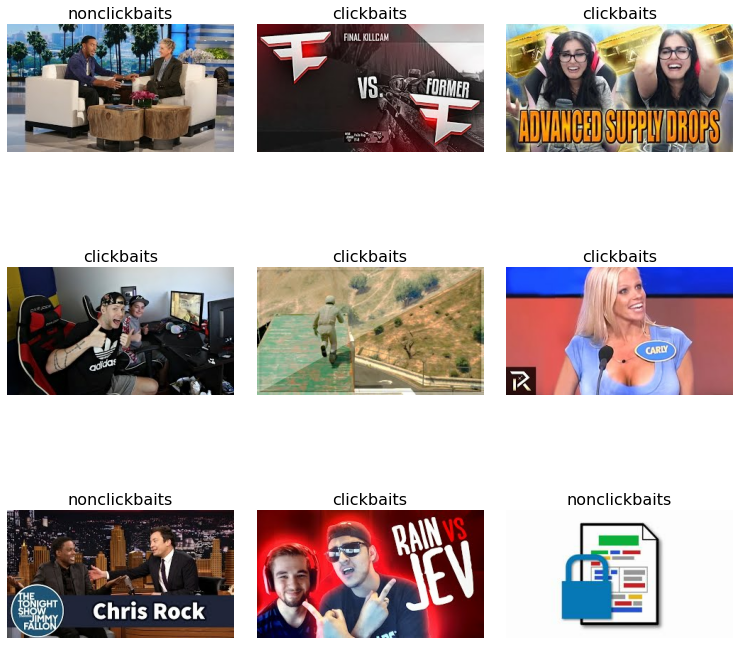

In [ ]:
display_9_images_from_dataset(dataset1)

#Resize and crop images to common size

In [ ]:
def resize_and_crop_image(image, label):
  # Resize and crop using "fill" algorithm:
  # always make sure the resulting image
  # is cut out from the source image so that
  # it fills the TARGET_SIZE entirely with no
  # black bars and a preserved aspect ratio.
  w = tf.shape(image)[0]
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[1]
  th = TARGET_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image, label
  
dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=AUTO)  

In [ ]:
for image, label in dataset2.take(10):
  print(image.numpy().shape, label.numpy().decode('utf-8'))

(180, 180, 3) clickbaits
(180, 180, 3) nonclickbaits
(180, 180, 3) clickbaits
(180, 180, 3) nonclickbaits
(180, 180, 3) clickbaits
(180, 180, 3) clickbaits
(180, 180, 3) nonclickbaits
(180, 180, 3) nonclickbaits
(180, 180, 3) clickbaits
(180, 180, 3) clickbaits


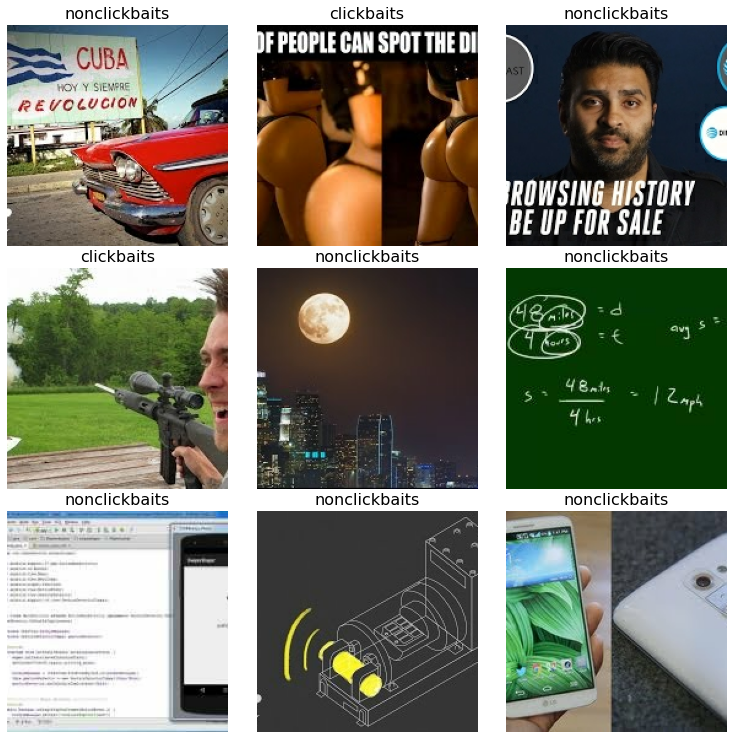

In [ ]:
display_9_images_from_dataset(dataset2)

#Speed test: too slow

In [ ]:
display_dataset = dataset2.batch(8)
for image, label in display_dataset.take(30):
  print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (8, 180, 180, 3), ['nonclickbaits', 'clickbaits', 'clickbaits', 'clickbaits', 'nonclickbaits', 'clickbaits', 'nonclickbaits', 'nonclickbaits'])
Image batch shape (8, 180, 180, 3), ['clickbaits', 'clickbaits', 'clickbaits', 'clickbaits', 'clickbaits', 'nonclickbaits', 'nonclickbaits', 'nonclickbaits'])
Image batch shape (8, 180, 180, 3), ['clickbaits', 'clickbaits', 'nonclickbaits', 'nonclickbaits', 'nonclickbaits', 'nonclickbaits', 'nonclickbaits', 'nonclickbaits'])
Image batch shape (8, 180, 180, 3), ['clickbaits', 'nonclickbaits', 'nonclickbaits', 'clickbaits', 'nonclickbaits', 'nonclickbaits', 'clickbaits', 'nonclickbaits'])
Image batch shape (8, 180, 180, 3), ['nonclickbaits', 'clickbaits', 'nonclickbaits', 'clickbaits', 'clickbaits', 'nonclickbaits', 'nonclickbaits', 'nonclickbaits'])
Image batch shape (8, 180, 180, 3), ['nonclickbaits', 'nonclickbaits', 'clickbaits', 'nonclickbaits', 'clickbaits', 'clickbaits', 'clickbaits', 'nonclickbaits'])
Image batch shape (

#Recompress the images

In [ ]:
def recompress_image(image, label):
  height = tf.shape(image)[0]
  width = tf.shape(image)[1]
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image, label, height, width

dataset3 = dataset2.map(recompress_image, num_parallel_calls=AUTO)
dataset3 = dataset3.batch(shard_size) # sharding: there will be one "batch" of images per file 

#Write dataset to TFRecord files

In [ ]:
# Three types of data can be stored in TFRecords: bytestrings, integers and floats
# They are always stored as lists, a single data element will be a list of size 1

def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): # float32
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
  

def to_tfrecord(tfrec_filewriter, img_bytes, label, height, width):  
  class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
  one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses

  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "class": _int_feature([class_num]),        # one class in the list
      
      # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
      "label":         _bytestring_feature([label]),          # fixed length (1) list of strings, the text label
      "size":          _int_feature([height, width]),         # fixed length (2) list of ints
      "one_hot_class": _float_feature(one_hot_class.tolist()) # variable length  list of floats, n=len(CLASSES)
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  
print("Writing TFRecords")
for shard, (image, label, height, width) in enumerate(dataset3):
  # batch size used as shard size here
  shard_size = image.numpy().shape[0]
  # good practice to have the number of records in the filename
  filename = PATH_OUTPUT + "{:02d}-{}.tfrec".format(shard, shard_size)
  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            image.numpy()[i], # re-compressed image: already a byte string
                            label.numpy()[i],
                            height.numpy()[i],
                            width.numpy()[i])
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file /content/drive/MyDrive/Colab Notebooks/clickbait_detection/root_dataset/tfrec_image_data/tfrecords-jpeg-180x180-nnn/thumbnails00-959.tfrec containing 959 records
Wrote file /content/drive/MyDrive/Colab Notebooks/clickbait_detection/root_dataset/tfrec_image_data/tfrecords-jpeg-180x180-nnn/thumbnails01-959.tfrec containing 959 records
Wrote file /content/drive/MyDrive/Colab Notebooks/clickbait_detection/root_dataset/tfrec_image_data/tfrecords-jpeg-180x180-nnn/thumbnails02-959.tfrec containing 959 records
Wrote file /content/drive/MyDrive/Colab Notebooks/clickbait_detection/root_dataset/tfrec_image_data/tfrecords-jpeg-180x180-nnn/thumbnails03-959.tfrec containing 959 records
Wrote file /content/drive/MyDrive/Colab Notebooks/clickbait_detection/root_dataset/tfrec_image_data/tfrecords-jpeg-180x180-nnn/thumbnails04-959.tfrec containing 959 records
Wrote file /content/drive/MyDrive/Colab Notebooks/clickbait_detection/root_dataset/tfrec_image_data/tfrecords-jpeg-18

#Read from TFRecord Dataset

In [ ]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64),  # two integers
        "one_hot_class": tf.io.VarLenFeature(tf.float32)        # a certain number of floats
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    
    label  = example['label']
    height = example['size'][0]
    width  = example['size'][1]
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    return image, class_num, label, height, width, one_hot_class


In [ ]:
# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

filenames = tf.io.gfile.glob(PATH_OUTPUT + "*.tfrec")
dataset4 = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
dataset4 = dataset4.with_options(option_no_order)
dataset4 = dataset4.map(read_tfrecord, num_parallel_calls=AUTO)
dataset4 = dataset4.shuffle(300)

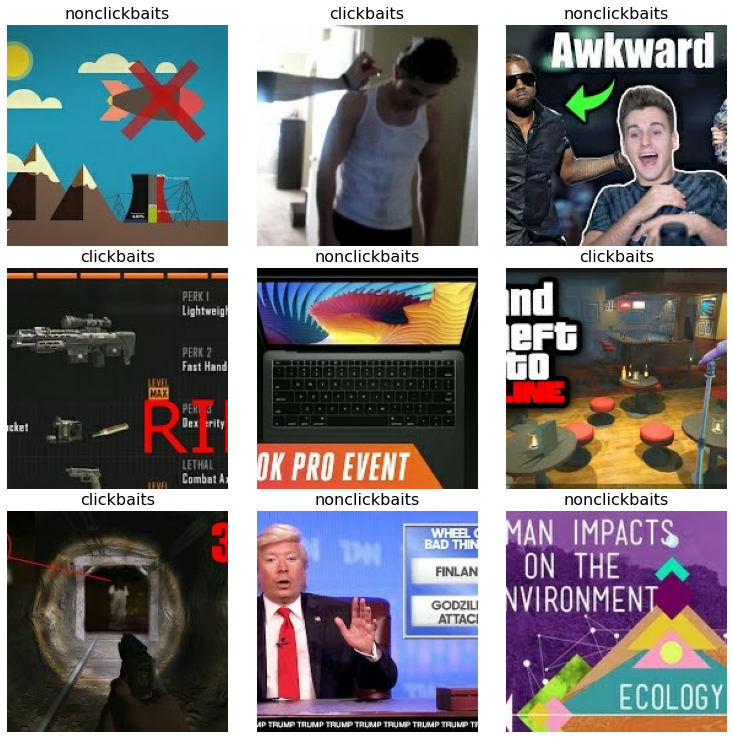

In [ ]:
display_dataset = dataset4.map(lambda image, class_num, label, height, width, one_hot_class: (image, label))
display_9_images_from_dataset(display_dataset)

#Speed test: fast

In [ ]:
for image, class_num, label, height, width, one_hot_class in dataset4.take(300):
    print("Image shape {}, {}x{} px, class={} ({:>10}, {})".format(image.numpy().shape, width, height, class_num, label.numpy().decode('utf8'), one_hot_class))

Image shape (180, 180, 3), 180x180 px, class=1 (nonclickbaits, [0. 1.])
Image shape (180, 180, 3), 180x180 px, class=1 (nonclickbaits, [0. 1.])
Image shape (180, 180, 3), 180x180 px, class=1 (nonclickbaits, [0. 1.])
Image shape (180, 180, 3), 180x180 px, class=0 (clickbaits, [1. 0.])
Image shape (180, 180, 3), 180x180 px, class=0 (clickbaits, [1. 0.])
Image shape (180, 180, 3), 180x180 px, class=1 (nonclickbaits, [0. 1.])
Image shape (180, 180, 3), 180x180 px, class=1 (nonclickbaits, [0. 1.])
Image shape (180, 180, 3), 180x180 px, class=1 (nonclickbaits, [0. 1.])
Image shape (180, 180, 3), 180x180 px, class=1 (nonclickbaits, [0. 1.])
Image shape (180, 180, 3), 180x180 px, class=1 (nonclickbaits, [0. 1.])
Image shape (180, 180, 3), 180x180 px, class=1 (nonclickbaits, [0. 1.])
Image shape (180, 180, 3), 180x180 px, class=0 (clickbaits, [1. 0.])
Image shape (180, 180, 3), 180x180 px, class=1 (nonclickbaits, [0. 1.])
Image shape (180, 180, 3), 180x180 px, class=0 (clickbaits, [1. 0.])
Imag